# Preliminaries - Installs, imports etc.



In [81]:
%reset
#@title Choose seed value
Seed = 1995 #@param {type:"integer"}
!rm -rf ./logs/
%load_ext tensorboard
%matplotlib inline

import datetime
import numpy as np
from numpy.random import Generator, PCG64
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import clone_model
from IPython.display import clear_output
from random import sample

tf.random.set_seed(Seed)  # Seeding Tensorflow.
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# MNIST Dataset - Loading & Preprocessing

In [82]:
num_classes = 10
img_rows, img_cols, img_colors = 28, 28, 1  # Greyscale images of 28 X 28.


(train_images, train_labels_base), (test_images, test_labels_base) = keras.datasets.mnist.load_data()
train_images = train_images.astype('float32')/255
test_images = test_images.astype('float32')/255
train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    
train_labels = keras.utils.to_categorical(train_labels_base, num_classes)
test_labels = keras.utils.to_categorical(test_labels_base, num_classes)



## Randomly choose two out of the ten classes in the MNIST dataset 
Randomly choose two out of the ten classes in the MNIST dataset. Filter out the dataset so that it includes only the two selected classes. Train a defensively distilled binary classifier over the filtered dataset, and eventually attack your classifier with the 4 different attack methods we have listed earlier.


In [83]:
train_labels.shape

(60000, 10)

In [84]:
train_images.shape

(60000, 28, 28, 1)

In [85]:
train_images_tensor = tf.Variable(train_images)
train_labels_tensor = tf.Variable(train_labels)
test_images_tensor = tf.Variable(test_images)
test_labels_tensor = tf.Variable(test_labels)

# Attack Functions

> Below are all available attacks.

## FGSM

In [86]:
@tf.function
def FastGradientSignMethod(model, images, labels, epsilon=0.3):
    with tf.GradientTape() as grad:
        true_label_tensor = labels
        input_tensor = images
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(true_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the FGSM formula is rather straight forward x`= x + epsilon * sign(loss(x,y))
    delta = tf.cast(tf.sign(adv_grads), tf.float32)
    
    delta = tf.multiply(epsilon, delta)
    adv_out = input_tensor + delta
    return adv_out

## TGSM

In [87]:
@tf.function
def TargetedGradientSignMethod(model, images, target, epsilon=0.3):
    with tf.GradientTape() as grad:
        target_label_tensor = target
        input_tensor = images
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(target_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Finally, the TGSM formula is rather straight forward x`= x - epsilon * sign(loss(x,y))
    delta = tf.cast(tf.sign(adv_grads), tf.float32)
    
    delta = tf.multiply(epsilon, delta)
    adv_out = input_tensor - delta
    return adv_out

## PGD

In [88]:
@tf.function 
def PGD_Step(model, images, prev_step, labels, epsilon, iter_eps, min_x, max_x, targeted):
    with tf.GradientTape() as grad:
        input_tensor = prev_step
        target_label_tensor = labels
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(target_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Perturb the input
    if targeted:
        adv_out = input_tensor - tf.multiply(iter_eps, tf.cast(tf.sign(adv_grads), tf.float32))
    else:
        adv_out = input_tensor + tf.multiply(iter_eps, tf.cast(tf.sign(adv_grads), tf.float32))

    # Project the perturbation to the epsilon ball (L2 projection)
    perturbation = adv_out - images
    norm = tf.reduce_sum(tf.square(perturbation), axis=(1,2,3), keepdims=True)
    norm = tf.sqrt(tf.maximum(10e-12, norm))
    factor = tf.minimum(1.0, tf.divide(epsilon, norm))
    adv_out = tf.clip_by_value(images + tf.multiply(perturbation, factor), min_x, max_x)

    return adv_out
  

@tf.function 
def PGD(model, images, labels, epsilon=0.1, iter_eps = 0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
    source = tf.identity(images)
    adv_out = images

    iteration = tf.constant(0, dtype=tf.int32)
    while tf.less(iteration, iterations):
        tf.print('Attack iteration:', iteration)
        adv_out.assign(PGD_Step(model, source, adv_out, labels, epsilon, iter_eps, min_x, max_x, targeted))
        iteration += 1

    return adv_out

## BIM

In [89]:
@tf.function
def BIM_Step(model, images, labels, epsilon, iter_eps, min_x, max_x, targeted):
    
    with tf.GradientTape() as grad:
        input_tensor = images
        target_label_tensor = labels
        predicted = model(input_tensor)
        adv_loss = keras.losses.categorical_crossentropy(target_label_tensor, predicted)
    adv_grads = grad.gradient(adv_loss, input_tensor)

    # Perturb the input
    if targeted:
        adv_out = input_tensor - tf.multiply(iter_eps, tf.cast(tf.sign(adv_grads), tf.float32))
    else:
        adv_out = input_tensor + tf.multiply(iter_eps, tf.cast(tf.sign(adv_grads), tf.float32))
        
    # Clip the intermdiate adversarial examples in order to ensure they are within
    # the valid data range
    delta = adv_out - images
    delta = tf.clip_by_value(delta, -epsilon, epsilon)
    adv_out = images + delta
    adv_out = tf.clip_by_value(adv_out, min_x, max_x)

    return adv_out


@tf.function
def BIM(model, images, labels, epsilon=0.1, iter_eps = 0.05, iterations=10, min_x=0.0, max_x=1.0, targeted=False):
    
    adv_out = images
    iteration = tf.constant(0, dtype=tf.int32)
    
    while tf.less(iteration, iterations):
        tf.print('Iteration:', iteration)
        # Note the use of 'assign' here instead of the '=' operator. This means, adv_out continues to point to the same
        # tensor, the same computation graph node, the same physical portion of GPU memory.
        # This is crucial because of the while loop structure. Recall that the 'tf.function' decoration creates a static 
        # computation graph. The python code is transformed into a graph only once.
        # Hence if we make adv_out point to a different graph node we will not be able to compute a valid gradient
        adv_out.assign(BIM_Step(model, adv_out, labels, epsilon, iter_eps, min_x, max_x, targeted))
        iteration += 1

    return adv_out

## Attack Choices & Evaluation

In [90]:
def commence_attack(model, attack_type, orig_images, true_labels, 
                    target_labels=None, attack_iters: int=1, 
                    epsilon: float=0.3, iter_eps: float=0.3):
    epsilon = tf.Variable(epsilon, dtype=tf.float32)
    iter_eps = tf.Variable(iter_eps)
    attack_iters = tf.Variable(attack_iters, dtype=tf.int32)

    if attack_type == "FGSM":
      adv_images = FastGradientSignMethod(model, orig_images, true_labels, 
                                          epsilon=epsilon)
      
    elif attack_type == "BIM(L_inf)":
      adv_images = BIM(model, orig_images, true_labels, epsilon=epsilon,
                       iter_eps=iter_eps, targeted=False, 
                       iterations=attack_iters)

    elif attack_type == "PGD(L_2)":
      adv_images = PGD(model, orig_images, true_labels, epsilon=epsilon,
                       iter_eps=iter_eps, targeted=False, 
                       iterations=attack_iters)
      
    elif attack_type == "PGD_target(L_2)":
      adv_images = PGD(model, orig_images, true_labels, epsilon=epsilon,
                       iter_eps=iter_eps, targeted=True, 
                       iterations=attack_iters)
      
    return adv_images.numpy()

def TestAttack(model, adv_images, orig_images, true_labels, target_labels=None, targeted=False):
    ''' 
    A simple utility funcion for evaluating the success of an attack
    '''
    score = model.evaluate(adv_images, true_labels, verbose=0)
    print('Test loss: {:.2f}'.format(score[0]))
    print('Successfully moved out of source class: {:.2f}'.format( 1 - score[1]))

    
    if targeted:  # if targeted is True
        score = model.evaluate(adv_images, target_labels, verbose=0)
        print('Test loss: {:.2f}'.format(score[0]))
        print('Successfully perturbed to target class: {:.2f}'.format(score[1]))
    
    dist = np.mean(np.sqrt(np.mean(np.square(adv_images - orig_images), axis=(1,2,3))))
    print('Mean perturbation distance: {:.2f}'.format(dist))

def perform_all_attacks(model, target_labels):
  attack_type_array = ["FGSM", "BIM(L_inf)", "PGD(L_2)"]#, "PGD_target(L_2)"]
  targeted_attacks = ["PGD_target(L_2)"]

  for attack_type in attack_type_array:
    # Performing the attack.
    is_attack_targeted: bool = attack_type in targeted_attacks
    print('\n', attack_type + " method",'\n')
    test_images_tensor = tf.Variable(test_images.copy(), dtype=tf.float32)
    test_labels_tensor = tf.Variable(test_labels.copy(), dtype=tf.float32)
    adv_images = commence_attack(model, attack_type, test_images_tensor, 
                                 test_labels_tensor, target_labels=target_labels,
                                 attack_iters=attack_iters, epsilon=epsilon, 
                                 iter_eps=iter_eps)

    # Evaluate the performance of the attack.
    TestAttack(model, adv_images, test_images, test_labels, 
               targeted=is_attack_targeted)

# Attack Config

> Shared parameters between all attacks.

In [91]:
#@title Attack Configuration
epsilon = 0.1 #@param {type:"number"}
iter_eps = 0.05 #@param {type:"number"}
#attack_type = "FGSM" #@param ["FGSM", "BIM(L_inf)", "PGD(L_2)",'PGD_target(L_2)']
attack_iters = 4 #@param {type:"integer"}

# Models For Investigation

Implementing a "scale-layer" in order to divide by some temperature $T$ before applying softmax activation.

In [92]:
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, temperature):
      super(ScaleLayer, self).__init__()
      self.temperature: float = temperature  # As pure Python float.
      self.scale = tf.Variable(temperature, dtype=tf.float32, trainable=False)  # As float Tensor.

    def get_config(self):
        return {"temperature": self.temperature}

    def call(self, inputs, training=None):
      if training:
        return inputs / self.scale  # Scale by temperature only during training
      return inputs  # Does nothing when testing...

In [93]:
def CNN_mnist_model_temp(img_rows, img_cols, img_colors, num_classes, 
                         learning_rate, temperature: float = 1,
                         name = "CNN_temperature"):
    activation = 'relu'
    model = keras.Sequential(name =name)
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(ScaleLayer(temperature))  # Note this scale-layer.
 
    model.add(layers.Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(learning_rate),
                metrics=[keras.metrics.CategoricalAccuracy()])
    return model


def CNN_mnist_model(img_rows, img_cols, img_colors, num_classes, learning_rate,
                    name = "CNN"):
    activation = 'relu'
    model = keras.Sequential(name =name)
    model.add(layers.Conv2D(8, kernel_size=(3, 3), input_shape=(img_rows, img_cols, img_colors), activation=activation))
    model.add(layers.Conv2D(8, (3, 3), activation=activation))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation=activation))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.Adadelta(learning_rate),
                metrics=[keras.metrics.CategoricalAccuracy()])
    return model


def train_model(model, max_epochs: int, train_images, train_labels, test_images, 
                test_labels, batch_size, callbacks_list, verbose=1):
    history = model.fit(train_images, train_labels,
        batch_size=batch_size,
        epochs=max_epochs,
        verbose=verbose,
        validation_data=(test_images, test_labels),
        callbacks=callbacks_list)
    return history

def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = keras.callbacks.LearningRateScheduler(lr_scheduler)

#Train The Teacher-Model

In [94]:
#@title Select The Model to Attack and Hyperparameters
selected_model = "CNN from Lecture 2" #@param ["CNN from Lecture 2", "NN from Ex 1"]
batch_size = 128 #@param {type:"integer"}
max_epochs = 5 #@param {type:"integer"}
learning_rate = 0.1 #@param {type:"number"}
lr_decay = 1e-6 #@param {type:"number"}
lr_drop = 6 #@param {type:"number"}
const_temperature = 30 #@param {type:"number"}


teacher_model = CNN_mnist_model_temp(img_rows, img_cols, img_colors, num_classes, learning_rate)
callbacks_list = [reduce_lr]

print('Base architecture - a simple convolutional neural network models')
print(f'Training-temperature: {const_temperature}')
print('Architecture of both teacher and student models')
teacher_model.summary()

print("Training the teacher model for all 10 classes of MNIST")
teacher_history = train_model(teacher_model, max_epochs, train_images, 
                              train_labels, test_images, test_labels, 
                              batch_size, callbacks_list)

Base architecture - a simple convolutional neural network models
Training-temperature: 30
Architecture of both teacher and student models
Model: "CNN_temperature"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 24, 24, 8)         584       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 8)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)     

# Attack The Teacher-Model

In [95]:
print("Attacking The teacher model for all 10 classes of MNIST")
perform_all_attacks(teacher_model, None)

Attacking The teacher model for all 10 classes of MNIST

 FGSM method 

Test loss: 0.83
Successfully moved out of source class: 0.28
Mean perturbation distance: 0.10

 BIM(L_inf) method 

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Test loss: 2.98
Successfully moved out of source class: 0.84
Mean perturbation distance: 0.12

 PGD(L_2) method 

Attack iteration: 0
Attack iteration: 1
Attack iteration: 2
Attack iteration: 3
Test loss: 0.14
Successfully moved out of source class: 0.04
Mean perturbation distance: 0.00


# Train The Student-Model, Using Defensive-Distillation

In [96]:
print("Training the student model for all 10 classes of MNIST")
student_model = CNN_mnist_model_temp(img_rows, img_cols, img_colors, num_classes, learning_rate)
# Fetching the 'probability' vectors for each train-sample.
train_softmax_vals = teacher_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
student_history = train_model(student_model, max_epochs, train_images, 
                              train_labels, test_images, test_labels, 
                              batch_size, callbacks_list)

Training the student model for all 10 classes of MNIST
Epoch 1/5
469/469 [==============================] - 3s 5ms/step - loss: 1.0275 - categorical_accuracy: 0.6654 - val_loss: 0.3189 - val_categorical_accuracy: 0.9112
Epoch 2/5
469/469 [==============================] - 2s 4ms/step - loss: 0.4723 - categorical_accuracy: 0.8540 - val_loss: 0.2376 - val_categorical_accuracy: 0.9325
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3815 - categorical_accuracy: 0.8842 - val_loss: 0.1955 - val_categorical_accuracy: 0.9433
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.3230 - categorical_accuracy: 0.9022 - val_loss: 0.1678 - val_categorical_accuracy: 0.9501
Epoch 5/5
469/469 [==============================] - 2s 5ms/step - loss: 0.2872 - categorical_accuracy: 0.9139 - val_loss: 0.1463 - val_categorical_accuracy: 0.9563


# Attack The Student Model

In [97]:
print("Attacking The student model for all 10 classes of MNIST")
perform_all_attacks(student_model, None)

Attacking The student model for all 10 classes of MNIST

 FGSM method 

Test loss: 0.83
Successfully moved out of source class: 0.27
Mean perturbation distance: 0.10

 BIM(L_inf) method 

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Test loss: 3.05
Successfully moved out of source class: 0.86
Mean perturbation distance: 0.13

 PGD(L_2) method 

Attack iteration: 0
Attack iteration: 1
Attack iteration: 2
Attack iteration: 3
Test loss: 0.16
Successfully moved out of source class: 0.05
Mean perturbation distance: 0.00


# Finding The Logits Values

In [98]:
student_model.pop()
student_model.pop()
logit_student = student_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
student_model.add(layers.Activation('softmax', name='softmax_no_temperature'))

teacher_model.pop()
teacher_model.pop()
logit_base = teacher_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
teacher_model.add(layers.Activation('softmax', name='softmax_no_temperature'))



#Filter The Database To Some Two Random Digits

In [99]:
num_classes = 2
image_sample=np.random.choice(10, 2, replace=False)

train_two_index= (np.where((train_labels_base == image_sample[0]) | (train_labels_base == image_sample[1])))[0]
test_two_index= (np.where((test_labels_base == image_sample[0]) | (test_labels_base== image_sample[1])))[0]
  
train_images=train_images[train_two_index]
train_labels=train_labels[train_two_index]
train_labels=train_labels[:,image_sample]

test_labels=test_labels[test_two_index]
test_labels=test_labels[:,image_sample]

test_images=test_images[test_two_index]

index_0 = (np.where(test_labels_base == image_sample[0]))[0]
index_1 = (np.where(test_labels_base == image_sample[1]) )[0]

# Repeat The Process for Two-class Models

In [100]:
print('Training Teach & Student Models for Two classes MNIST')
binary_teacher_model = CNN_mnist_model_temp(img_rows, img_cols, img_colors, num_classes, learning_rate)
callbacks_list = [reduce_lr]

print('Base architecture - a simple convolutional neural network models')
print(f'Training-temperature: {const_temperature}')

print("Training the teacher model for all 10 classes of MNIST")
teacher_history = train_model(binary_teacher_model, max_epochs, train_images, 
                              train_labels, test_images, test_labels, 
                              batch_size, callbacks_list)

print("Attacking The teacher model for all 2 classes of MNIST")
perform_all_attacks(binary_teacher_model, None)

print("Training the student model for all 10 classes of MNIST")
binary_student_model = CNN_mnist_model_temp(img_rows, img_cols, img_colors, num_classes, learning_rate)
# Fetching the 'probability' vectors for each train-sample.
train_softmax_vals = binary_teacher_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
student_history = train_model(binary_student_model, max_epochs, train_images, 
                              train_labels, test_images, test_labels, 
                              batch_size, callbacks_list)

print("Attacking The student model for all 2 classes of MNIST")
perform_all_attacks(binary_student_model, None)

student_model.pop()
student_model.pop()
binary_logit_student = binary_student_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
binary_student_model.add(layers.Activation('softmax', name='softmax_no_temperature'))

teacher_model.pop()
teacher_model.pop()
binary_logit_base = binary_teacher_model.predict(
    train_images, batch_size, workers=2, use_multiprocessing=True)
binary_teacher_model.add(layers.Activation('softmax', name='softmax_no_temperature'))

Training Teach & Student Models for Two classes MNIST
Base architecture - a simple convolutional neural network models
Training-temperature: 30
Training the teacher model for all 10 classes of MNIST
Epoch 1/5
99/99 [==============================] - 1s 7ms/step - loss: 0.3972 - categorical_accuracy: 0.8280 - val_loss: 0.1051 - val_categorical_accuracy: 0.9801
Epoch 2/5
99/99 [==============================] - 0s 5ms/step - loss: 0.1223 - categorical_accuracy: 0.9629 - val_loss: 0.0453 - val_categorical_accuracy: 0.9886
Epoch 3/5
99/99 [==============================] - 0s 5ms/step - loss: 0.0827 - categorical_accuracy: 0.9722 - val_loss: 0.0319 - val_categorical_accuracy: 0.9915
Epoch 4/5
99/99 [==============================] - 0s 5ms/step - loss: 0.0707 - categorical_accuracy: 0.9768 - val_loss: 0.0256 - val_categorical_accuracy: 0.9929
Epoch 5/5
99/99 [==============================] - 0s 5ms/step - loss: 0.0629 - categorical_accuracy: 0.9790 - val_loss: 0.0228 - val_categorical_acc

# Plotting Softmax & Logits Values Against Each Other

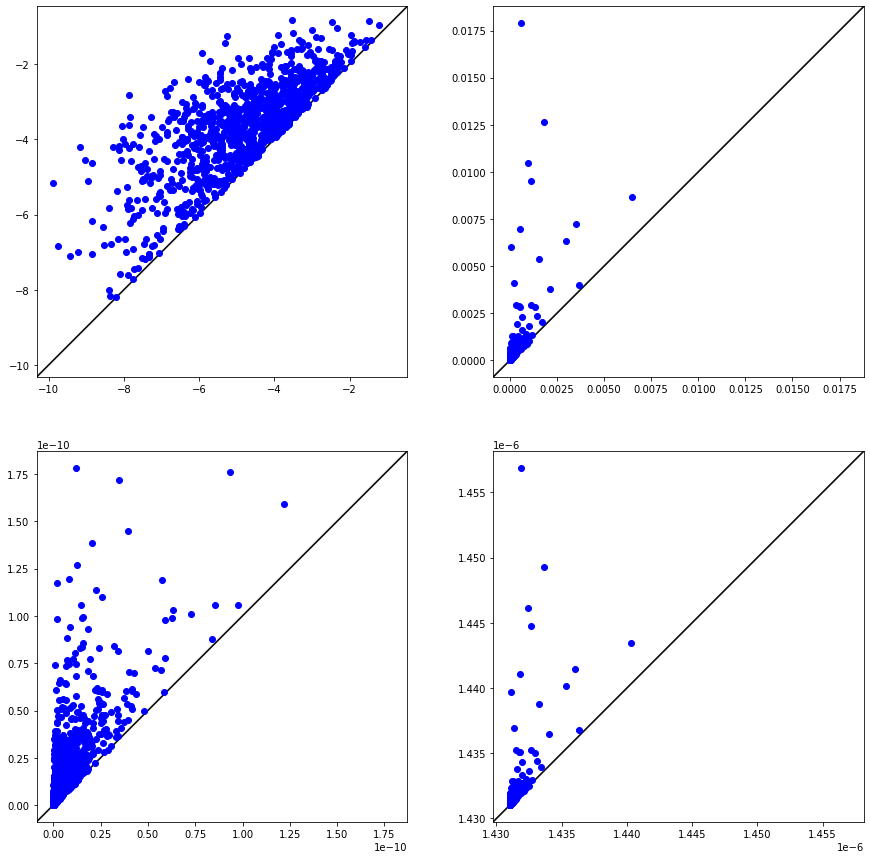

In [101]:
from scipy.special import softmax

logit_student.sort()
logit_base.sort()

softmax_student = softmax(logit_student)
softmax_base = softmax(logit_base)
fig, axs = plt.subplots(2, 2,figsize=(15,15))

axs[0, 0].scatter(logit_student[index_0,0], logit_student[index_0,1], color='blue')
axs[0, 1].scatter(logit_base[index_0,0], logit_base[index_0,1], color='blue')

axs[1, 0].scatter(softmax_student[index_0,0], softmax_student[index_0,1],  color='blue')
axs[1, 1].scatter(softmax_base[index_0,0], softmax_base[index_0,1],  color='blue')



# now plot both limits against eachother
for i in range(2):
    for j in range(2):
        lims = [
        np.min([axs[i,j].get_xlim(), axs[i,j].get_ylim()]),  # min of both axes
        np.max([axs[i,j].get_xlim(), axs[i,j].get_ylim()])] # max of both axes

        axs[i,j].plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        axs[i,j].plot(lims, lims, 'k-', alpha=0.75, zorder=0)

        axs[i,j].set_aspect('equal')
        axs[i,j].set_xlim(lims)
        axs[i,j].set_ylim(lims)



